# Facial Keypoints Detection
## W207 Final Project December 2017
### Arunima Kayath, Kathleen Wang, Anamika Sinha & Scott A. George

In [182]:
import os

import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from decimal import *
import tensorflow as tf
import time
from datetime import datetime
import matplotlib.pyplot as plt
from tensorflow.contrib.layers import fully_connected

# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

## Loading Data

In [183]:
scott = False
aws = False
tensorboard_log = False


if scott:
    c = ''
    FTRAIN = '/data/facial/training.csv'
    FTEST = '/data/facial/test.csv'
elif aws:
    FROOT = ''
    FTRAIN = '/data/training.csv'
    FTEST = '/data/test.csv'
else:
    FROOT = os.getcwd() # Path to your project folder
    FTRAIN = FROOT + '/data/training.csv'
    FTEST = FROOT + '/data/test.csv'

if tensorboard_log:
    root_logdir = FROOT + "tf_logs"

Helper function to load data

In [184]:
np.random.seed(0)
def load(test = False, cols = None):
    '''Loads data from FTEST if *test* is true, otherwise from FTRAIN.' 
    Pass a list of *cols* if you are only interested in a
    subset of the target columns'''
    
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname)) #load pandas dataframe

    
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im,sep=' ')) 
    #image column has pixel values separated by space; convert the values to numpy arrays
    
    if cols: #get a subset of columns
        df = df[list(cols) + ['Image']]
        
    print('Count of observations in training data by features')
    print(df.count()) #prints number of values for each column
    df = df.dropna() #drop all rows that have missing values in them
    
    X = np.vstack(df['Image'].values)/255
    X = X.astype(np.float32)
    
    if not test:
        y  = df[df.columns[:-1]].values
        y = (y-48)/48
        shuffle = np.random.permutation(np.arange(X.shape[0]))
        X, y = X[shuffle], y[shuffle]
        y = y.astype(np.float32)
    else:
        y = None
        
    return X,y


In [185]:
np.random.seed(0)
X, y = load()

print('Total training data')
print("X.shape = = {}; X.min == {:.3f}; X.max == {:.3f}".format(X.shape, X.min(),X.max()))
print("y.shape = = {}; y.min == {:.3f}; y.max == {:.3f}".format(y.shape, y.min(),y.max()))


Count of observations in training data by features
left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       22

Save 20% data to be used as dev data, carve out dev data and load test data

In [186]:
np.random.seed(0)
dev_size = 0.2
#setting aside a 20% sample for validation

x_train, x_dev, y_train, y_dev = train_test_split(X, y, test_size = dev_size)

x_test, _ = load(test=True)

print('Training data split into train and dev data')
print("x_train.shape = = {}; x_train.min == {:.3f}; x_train.max == {:.3f}".format(x_train.shape, x_train.min(),x_train.max()))
print("y_train.shape = = {}; y_train.min == {:.3f}; y_train.max == {:.3f}".format(y_train.shape, y_train.min(),y_train.max()))
print("x_dev.shape = = {}; x_dev.min == {:.3f}; x_dev.max == {:.3f}".format(x_dev.shape, x_dev.min(),x_dev.max()))
print("y_dev.shape = = {}; y_dev.min == {:.3f}; y_dev.max == {:.3f}".format(y_dev.shape, y_dev.min(),y_dev.max()))

Count of observations in training data by features
ImageId    1783
Image      1783
dtype: int64
Training data split into train and dev data
x_train.shape = = (1712, 9216); x_train.min == 0.000; x_train.max == 1.000
y_train.shape = = (1712, 30); y_train.min == -0.916; y_train.max == 0.996
x_dev.shape = = (428, 9216); x_dev.min == 0.000; x_dev.max == 1.000
y_dev.shape = = (428, 30); y_dev.min == -0.920; y_dev.max == 0.980


## Helper functions

### 1. plot_sample: plots sample pictures

In [187]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

In [188]:
np.random.seed(1)
def shuffle_run_batch(Xnp, ynp, Xdev, ydev, batch_size, epoch):
    """function takes training and dev data, shuffle the train data and run TF optimizer in batches for a given epoch
    It returns the average loss for training and eval of all the batches ran in the epoch.
    It expects to run with tensorboard."""

    shuffle = np.random.permutation(np.arange(Xnp.shape[0])) #shuffle the training data in each epoch
    Xnp, ynp = Xnp[shuffle], ynp[shuffle]

    # initialize variables to hold loss information for each epoch
    #loss_train = 0
    #loss_dev = 0
    batches = Xnp.shape[0]//batch_size


    for i in range(int(batches)): #run through most of the data points in each epoch
        X_batch,y_batch = Xnp[i*batch_size:(i+1)*batch_size,:], ynp[i*batch_size:(i+1)*batch_size]
        if tensorboard_log:
            if i % 10 == 0:
                train_summary_str = sqrt_loss_summary.eval(feed_dict={X: X_batch, y: y_batch, training: True})
                dev_summary_str = sqrt_loss_summary.eval(feed_dict={X: Xdev, y: ydev, training: False})
                step = epoch * batches + i
                train_writer.add_summary(train_summary_str, step)
                dev_writer.add_summary(dev_summary_str, step)

        sess.run(optimizer, feed_dict = {X:X_batch,y:y_batch, training:True})

    

        loss_train = loss.eval(feed_dict = {X:X_batch,y:y_batch,  training:True})            
        loss_dev = loss.eval(feed_dict = {X:Xdev,y:ydev, training:False})

    
    return loss_train, loss_dev
       
            

In [189]:
# *might* need to double check correctly formatted input
def plot_loss (train_loss_data, dev_loss_data):
    
    plt.plot(train_loss_data[:,1], label="train")
    plt.plot(dev_loss_data[:,1], linewidth=3, label="valid")
    plt.grid()
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.yscale("log")
    plt.show()

In [190]:
# *might* need to double check correctly formatted input
def plot_pred (x_dev, y_pred):
    
    fig = plt.figure(figsize=(16, 16))
    fig.subplots_adjust(
        left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(16):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        plot_sample(x_dev[i], y_pred[i], ax)
    plt.show()
    


## First model: 1 hidden layer simple neural net

Define parameters

In [154]:
learning_rate = 0.01
momentum = 0.9

n_epochs = 2
batch_size = 50


n_inputs = X.shape[1] 
n_hidden1 = 100
n_outputs = 30


Construct the tensorflow graph for the first network

0 Train loss:0.240 Dev loss:0.239 ratio train/dev:1.00
Total time taken: 1.8002910614013672


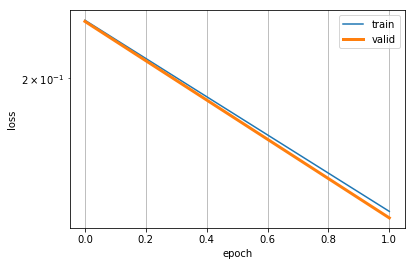

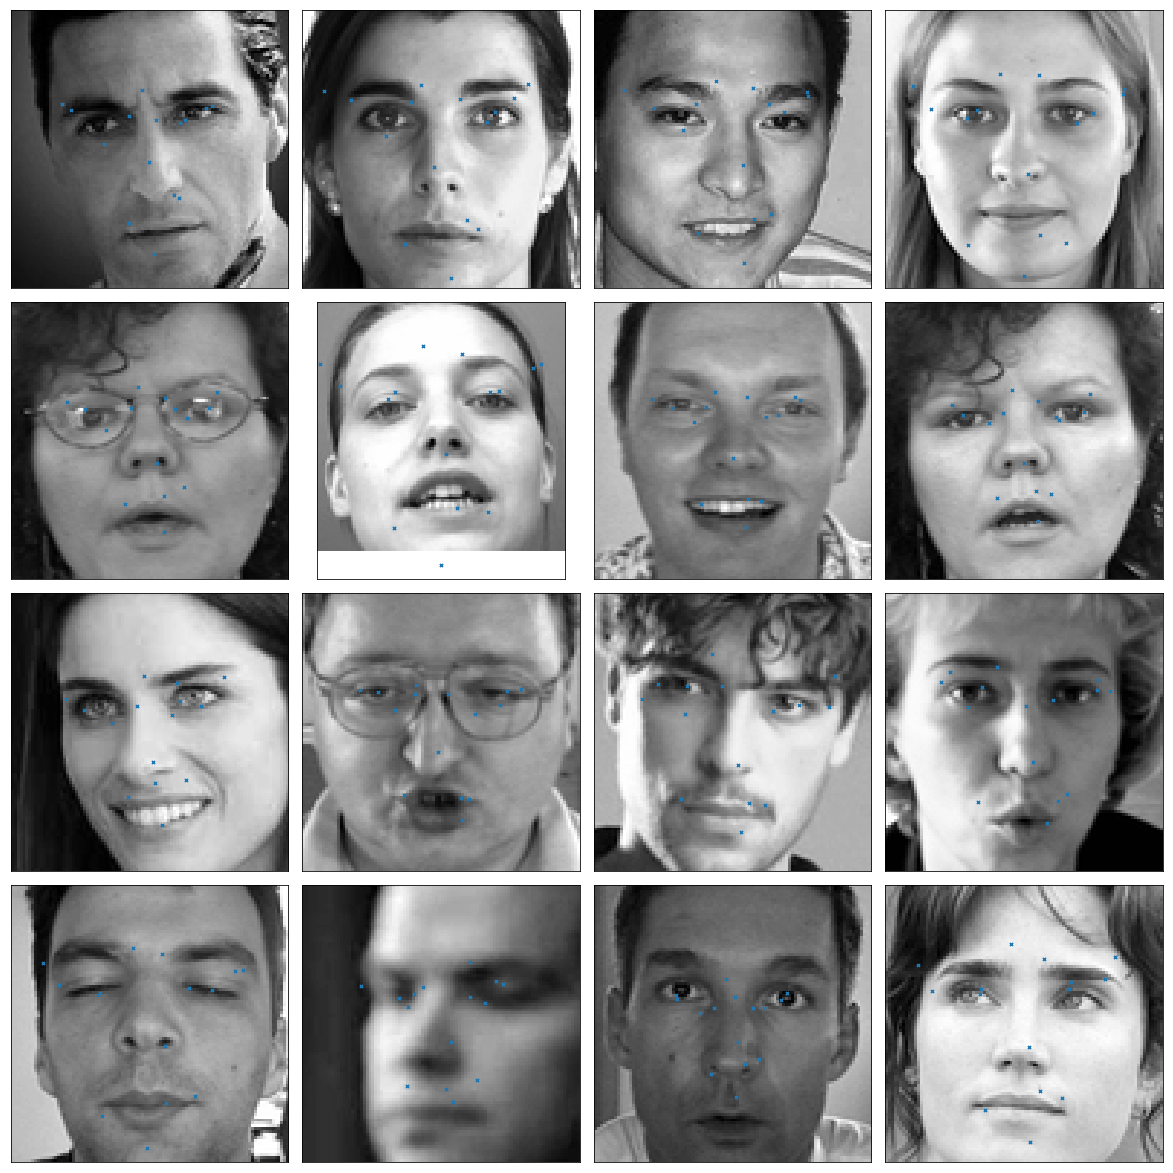

In [126]:
np.random.seed(1)
tf.reset_default_graph()

X = tf.placeholder(tf.float32,shape = (None,n_inputs),name = 'X')
y = tf.placeholder(tf.float32,shape = (None,n_outputs),name = 'y')
training = tf.placeholder(tf.bool)

if tensorboard_log:
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    logdir = "{}/run-{}/".format(root_logdir, now)


with tf.name_scope('dnn'):
    hidden1 = fully_connected(X,n_hidden1,scope = 'hidden1')
    pred_keypoints = fully_connected(hidden1,n_outputs,activation_fn = None,scope = 'outputs')
    
    
with tf.name_scope('loss'):
    loss = tf.reduce_mean(np.square(pred_keypoints - y))   
    sqrt_loss = tf.sqrt(loss)

with tf.name_scope('train'):
    optimizer = tf.train.MomentumOptimizer(learning_rate = learning_rate,momentum = momentum).minimize(loss) 
    #works better than gradientdescentoptimizer

#for tensorboard
with tf.name_scope('summaries'):
    sqrt_loss_summary = tf.summary.scalar('sqrt_loss', sqrt_loss)


if tensorboard_log:
    train_writer = tf.summary.FileWriter(logdir + '/train', tf.get_default_graph())
    dev_writer =  tf.summary.FileWriter(logdir + '/dev')
    
init = tf.global_variables_initializer()


train_loss_data = np.zeros((n_epochs,2))
dev_loss_data = np.zeros((n_epochs,2))

time_start = time.time()
time_1000_start = time.time()

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        
        # note this is includes the for-loop for batching
        loss_train,loss_dev = shuffle_run_batch (x_train, y_train, x_dev, y_dev, batch_size, epoch)
                    
        train_loss_data[epoch,:] = epoch,np.sqrt(loss_train)
        dev_loss_data[epoch,:] = epoch,np.sqrt(loss_dev)

            
        if epoch%10 == 0:
            print(epoch,'Train loss:%0.3f'%np.sqrt(loss_train),
                  'Dev loss:%0.3f'%np.sqrt(loss_dev),
                  'ratio train/dev:%0.2f'%np.sqrt(loss_train/loss_dev))
            
            
    time_end = time.time()  
    
    y_pred = sess.run(pred_keypoints,feed_dict = {X: x_dev})
   
    print('Total time taken:',time_end-time_start)

#if tensorboard_log: 
if tensorboard_log:
    train_writer.close()
    dev_writer.close()
    
plt.figure()
plot_loss (train_loss_data, dev_loss_data)
plot_pred (x_dev, y_pred)


## Second model: Convolutional Neural Network

### 1. Base convolutional NN:
### optimizer = MomentumOptimizer, 
Define parameters

In [191]:
learning_rate = 0.01
momentum = 0.9
# optimizer used
optimize_func = tf.train.MomentumOptimizer
# (learning_rate = learning_rate,momentum = momentum,use_nesterov = True).minimize(loss)

n_epochs = 2
batch_size = 128

n_inputs = X.shape[1] 
n_outputs = 30


# Convolutional Layer 1.
filter_size1 = 3          # Convolution filters are 3 x 3 pixels.
num_filters1 = 32         # There are 32 of these filters.
dropout_keep_prob1 = 1


# Convolutional Layer 2.
filter_size2 = 2          # Convolution filters are 2 x 2 pixels.
num_filters2 = 64         # There are 64 of these filters.
dropout_keep_prob2 = 1


# Convolutional Layer 3.
filter_size3 = 2          # Convolution filters are 2 x 2 pixels.
num_filters3 = 128         # There are 128 of these filters.
dropout_keep_prob3 = 1


# Fully-connected layer.
fc_size4 = 1000             # Number of output neurons in fully-connected layer1.
dropout_keep_prob4 = 1      # Drop about keep robability if drop outs are applied
fc_size5 = 1000             # Number of output neurons in fully-connected layer2.
dropout_keep_prob5 = 1
dropout_keep_prob6 = 1



# # data_augmentation = False
# # learning_rate_decay = True
# # momentum_increase = True
# dropout = True

#model_name = "3con_2fc_b" + str(batch_size) + "_e" + str(num_epochs - 1)
# if data_augmentation:
#     model_name += "_aug"
# if learning_rate_decay:
#     model_name += "_lrdec"
# if momentum_increase:
#     model_name += "_mominc"
# if dropout:
#     model_name += "_dr"

### Define helper function to:   
### 1) create convoluted layer variables  
### 2) create dense layer and   
### 3) flatten a conv layer for the dense layer

In [192]:
#Building a convolutional layer

def new_conv_relu_layer(input, filter_size, num_filters, is_training, dropout_keep_prob = 1):
    """Takes parameters and set up a convoluted layer with possible pooling
    It returns the layer as well as the weights"""

    weights = tf.get_variable( 'weights', 
        shape = [filter_size, filter_size, input.get_shape()[3], num_filters],
        initializer = tf.contrib.layers.xavier_initializer()
      )
    
    biases = tf.get_variable( 'biases',
        shape = [num_filters],
        initializer=tf.constant_initializer(0.0)
      )
    
    conv = tf.nn.conv2d(input=input, filter=weights, strides=[1, 1, 1, 1], padding='SAME')
    
    
    layer = tf.nn.conv2d(input=input, filter=weights, strides=[1, 1, 1, 1], padding='SAME')


    layer += biases

    layer = tf.nn.max_pool(value=layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],padding='SAME')

    layer = tf.nn.relu(layer)    
    
    # apply drop out by specifying a drop_out_keep_prob
    layer = tf.cond(is_training, lambda: tf.nn.dropout(layer, keep_prob = dropout_keep_prob), lambda: layer)
    
    return layer, weights

In [193]:
#Building a fully connected layer, with relu
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu,
                 is_training ,
                 dropout_keep_prob = 1):       # no relu for the output dense layer

    # Create new weights and biases.
    weights = tf.get_variable( 'weights', 
        shape = [num_inputs, num_outputs],
        initializer = tf.contrib.layers.xavier_initializer()
      )
    
    biases = tf.get_variable( 'biases',
        shape = [num_outputs],
        initializer=tf.constant_initializer(0.0)
      )
        

    layer = tf.matmul(input, weights) + biases
    
    if use_relu:
        layer = tf.nn.relu(layer)
    
    layer = tf.cond(is_training, lambda: tf.nn.dropout(layer, keep_prob = dropout_keep_prob), lambda: layer)

    return layer

In [194]:
# build flatten layer function to flatten conv layer for the fully connected layer
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features

In [137]:
#changing keep_prob values
dropout_keep_prob1 = 0.9
dropout_keep_prob2 = 0.8
dropout_keep_prob3 = 0.8
dropout_keep_prob4 = 0.5


In [215]:
#please give any unique name you want to give to the model for testing various paramaters.
    #It wil get appended to "basic_conv_net"
unique_name = ""
model_name = "basic_conv_net_2" + unique_name
model_path =  FROOT + "/models/"+ model_name + "/model.ckpt"
train_history_path = FROOT + "/models/" + model_name + "/train_history"
os.makedirs(model_path + model_name + "/", exist_ok = True)

0 Train loss:0.127 Dev loss:0.123 ratio train/dev:1.03
Total time taken: 176.75811004638672
Model file: /Users/anamika/W207_local/class/models/basic_conv_net_1/model.ckpt
Train history file: /Users/anamika/W207_local/class/models/basic_conv_net_1/train_history


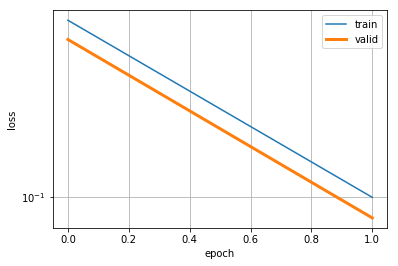

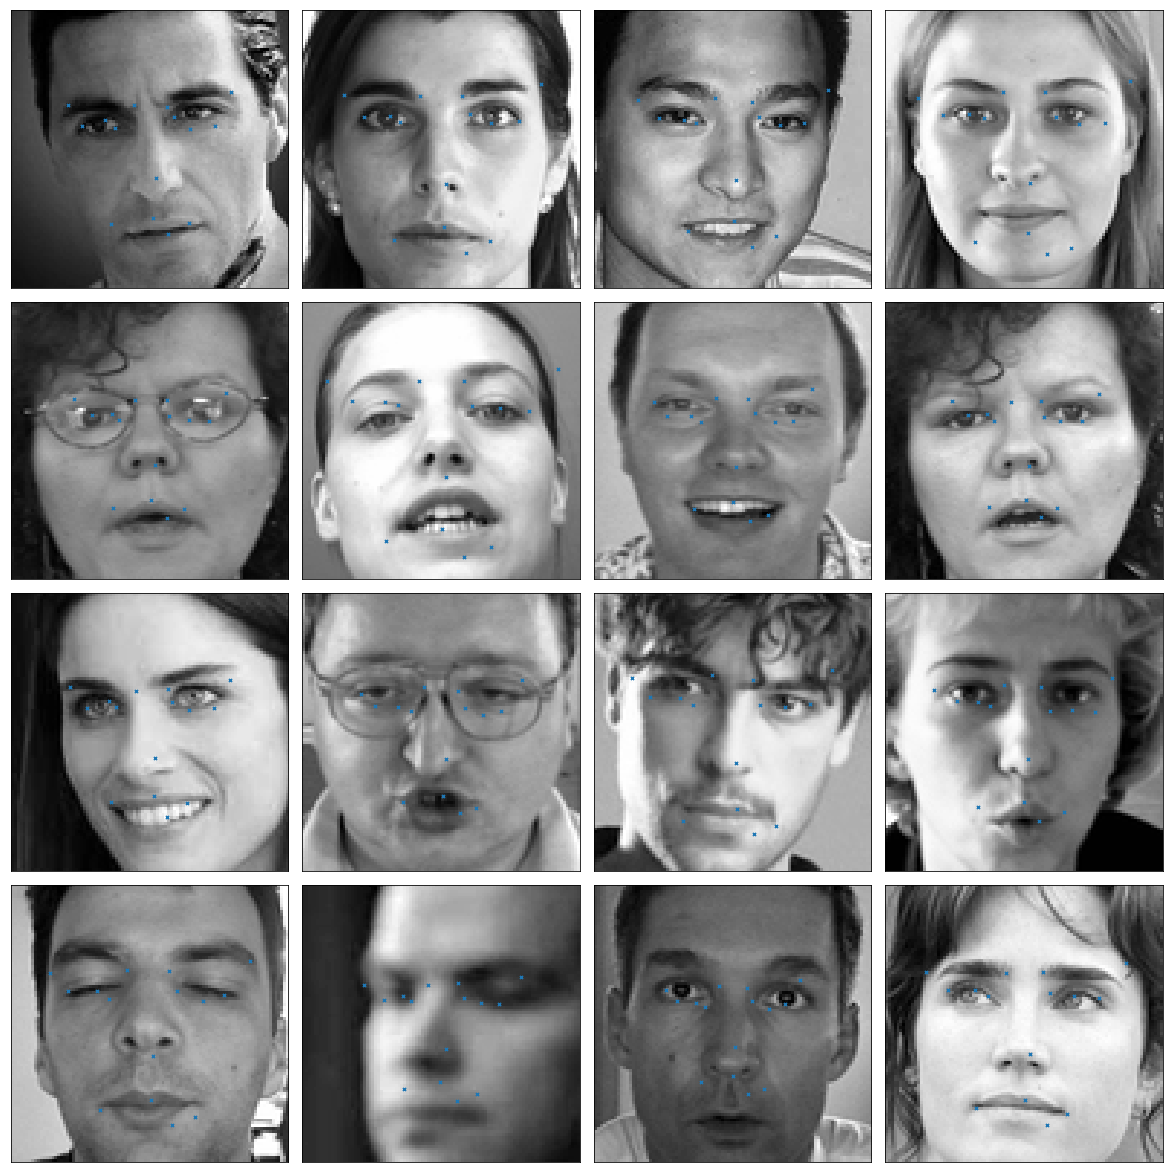

In [198]:
np.random.seed(1)
graph_base = tf.Graph()
with graph_base.as_default():

    if tensorboard_log:
        now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
        logdir = "{}/run-{}/".format(root_logdir, now)

    # def 
    # is_train = True
    #input data
    X = tf.placeholder(tf.float32,[None,X.shape[1]])
    y = tf.placeholder(tf.float32,[None,y.shape[1]])
    training = tf.placeholder(tf.bool)
    
    
    
    #convert x into 4-D input
    #2nd and 3rd dimension is image width and height, final dimension is number of color channels
    x_image = tf.reshape(X,[-1,96,96,1]) 

    #First convolutional layer
    with tf.variable_scope('conv1'):
        layer_conv1, weights_conv1 = new_conv_relu_layer (input = x_image, 
                                                          filter_size = filter_size1, 
                                                          num_filters = num_filters1, 
                                                          is_training = training,
                                                          dropout_keep_prob = dropout_keep_prob1)

    #Second convolutional layer
    with tf.variable_scope('conv2'):
        layer_conv2, weights_conv2 = new_conv_relu_layer (input = layer_conv1, 
                                                          filter_size = filter_size2, 
                                                          num_filters = num_filters2, 
                                                          is_training = training,
                                                          dropout_keep_prob = dropout_keep_prob2)

    #Thrid convolutional layer
    with tf.variable_scope('conv3'):
        layer_conv3, weights_conv3 = new_conv_relu_layer (input = layer_conv2, 
                                                          filter_size = filter_size3, 
                                                          num_filters = num_filters3, 
                                                          is_training = training,
                                                          dropout_keep_prob = dropout_keep_prob3)    

    #Flatten conv3 output for dense nn layer 1
    layer_flat, num_features = flatten_layer(layer_conv3)

    #Densely connected layer1
    with tf.variable_scope('fc4'):
        layer_fc4 = new_fc_layer(input =layer_flat,
                                num_inputs = num_features,
                                num_outputs = fc_size4,
                                use_relu = True,
                                is_training = training,
                                dropout_keep_prob = dropout_keep_prob4)

    #Densely connected layer2
    with tf.variable_scope('fc5'):
        layer_fc5 = new_fc_layer(input =layer_fc4,
                                num_inputs = fc_size4,
                                num_outputs = fc_size5,
                                use_relu = True,
                                is_training = training,
                                dropout_keep_prob = dropout_keep_prob5)    

    #Densely connected output layer
    with tf.variable_scope('fc6'):
        layer_f6 = new_fc_layer(input =layer_fc5,
                                num_inputs = fc_size5,
                                num_outputs = n_outputs,
                                use_relu = False,
                                is_training = training,
                                dropout_keep_prob = dropout_keep_prob6)       


    #loss function
    with tf.name_scope('loss'):
        loss = tf.reduce_mean(np.square(layer_f6 - y))
        sqrt_loss = tf.sqrt(loss)
        
    #for tensorboard
    with tf.name_scope('summaries'):
        sqrt_loss_summary = tf.summary.scalar('sqrt_loss', sqrt_loss)
        
    #for saving
    #with tf.name_scope(model_name):

        
    # optimizer
    optimizer = optimize_func(learning_rate = learning_rate,momentum = momentum,use_nesterov = True).minimize(loss)

    train_loss_data = np.zeros((n_epochs,2))
    dev_loss_data = np.zeros((n_epochs,2))
    y_pred = np.zeros((x_dev.shape[0],y.shape[1]))

    # logger
    if tensorboard_log:
        train_writer = tf.summary.FileWriter(logdir + '/train', tf.get_default_graph())
        dev_writer =  tf.summary.FileWriter(logdir + '/dev')

    
time_start = time.time()
time_1000_start = time.time()

    
with tf.Session(graph=graph_base) as sess:
    sess.run(tf.global_variables_initializer())
    
    #for saving model 
    saver = tf.train.Saver()
    
    for epoch in range(n_epochs):
        #print('starting epoch:',epoch)
        
        loss_train,loss_dev = shuffle_run_batch (x_train, y_train, x_dev, y_dev, batch_size, epoch)

        train_loss_data[epoch,:] = epoch,np.sqrt(loss_train)
        dev_loss_data[epoch,:] = epoch,np.sqrt(loss_dev)

        
        if epoch%5 == 0:
            print(epoch,'Train loss:%0.3f'%np.sqrt(loss_train),'Dev loss:%0.3f'%np.sqrt(loss_dev),'ratio train/dev:%0.2f'%np.sqrt(loss_train/loss_dev))
        
    time_end = time.time()
    print('Total time taken:',time_end-time_start)
    
    # Save model weights for future use.
    
    
    save_path = saver.save(sess, model_path)
    print("Model file: " + save_path)
    np.savez(train_history_path, train_loss_history = train_loss_data, valid_loss_history = dev_loss_data)
    print("Train history file: " + train_history_path)
    
    for i in range(int(x_dev.shape[0]//batch_size)): #doing predictions in batches
            X_batch = x_dev[i*batch_size:(i+1)*batch_size,:]
            y_pred [i*batch_size:(i+1)*batch_size] = sess.run(layer_f6,feed_dict = {X:X_batch, training:False})

#Plot a graph of the train vs test loss data:
    

plot_loss (train_loss_data, dev_loss_data)

if tensorboard_log:
    train_writer.close()
    dev_writer.close()

#Examine a few test cases to see accuracy of prediction:    
plot_pred (x_dev, y_pred)

# 
# def plot_sample(x, y, axis):
#     img = x.reshape(96, 96)
#     axis.imshow(img, cmap='gray')
#     axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

# fig = plt.figure(figsize=(16, 16))
# fig.subplots_adjust(
#     left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# for i in range(16):
#     ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
#     plot_sample(X_test[i], y_pred[i], ax)

# plt.show()



 RESTORING SESSION FOR WEIGHTS INITIALIZATION
all variables: conv1/weights
all variables: conv1/biases
all variables: conv2/weights
all variables: conv2/biases
all variables: conv3/weights
all variables: conv3/biases
all variables: fc4/weights
all variables: fc4/biases
all variables: fc5/weights
all variables: fc5/biases
all variables: fc6/weights
all variables: fc6/biases
all variables: conv1/weights/Momentum
all variables: conv1/biases/Momentum
all variables: conv2/weights/Momentum
all variables: conv2/biases/Momentum
all variables: conv3/weights/Momentum
all variables: conv3/biases/Momentum
all variables: fc4/weights/Momentum
all variables: fc4/biases/Momentum
all variables: fc5/weights/Momentum
all variables: fc5/biases/Momentum
all variables: fc6/weights/Momentum
all variables: fc6/biases/Momentum
INFO:tensorflow:Restoring parameters from /Users/anamika/W207_local/class/models/basic_conv_net_1/model.ckpt
 Model loaded from: /Users/anamika/W207_local/class/models/basic_conv_net_1/m

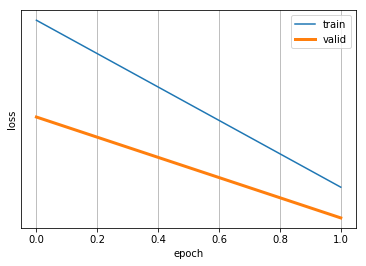

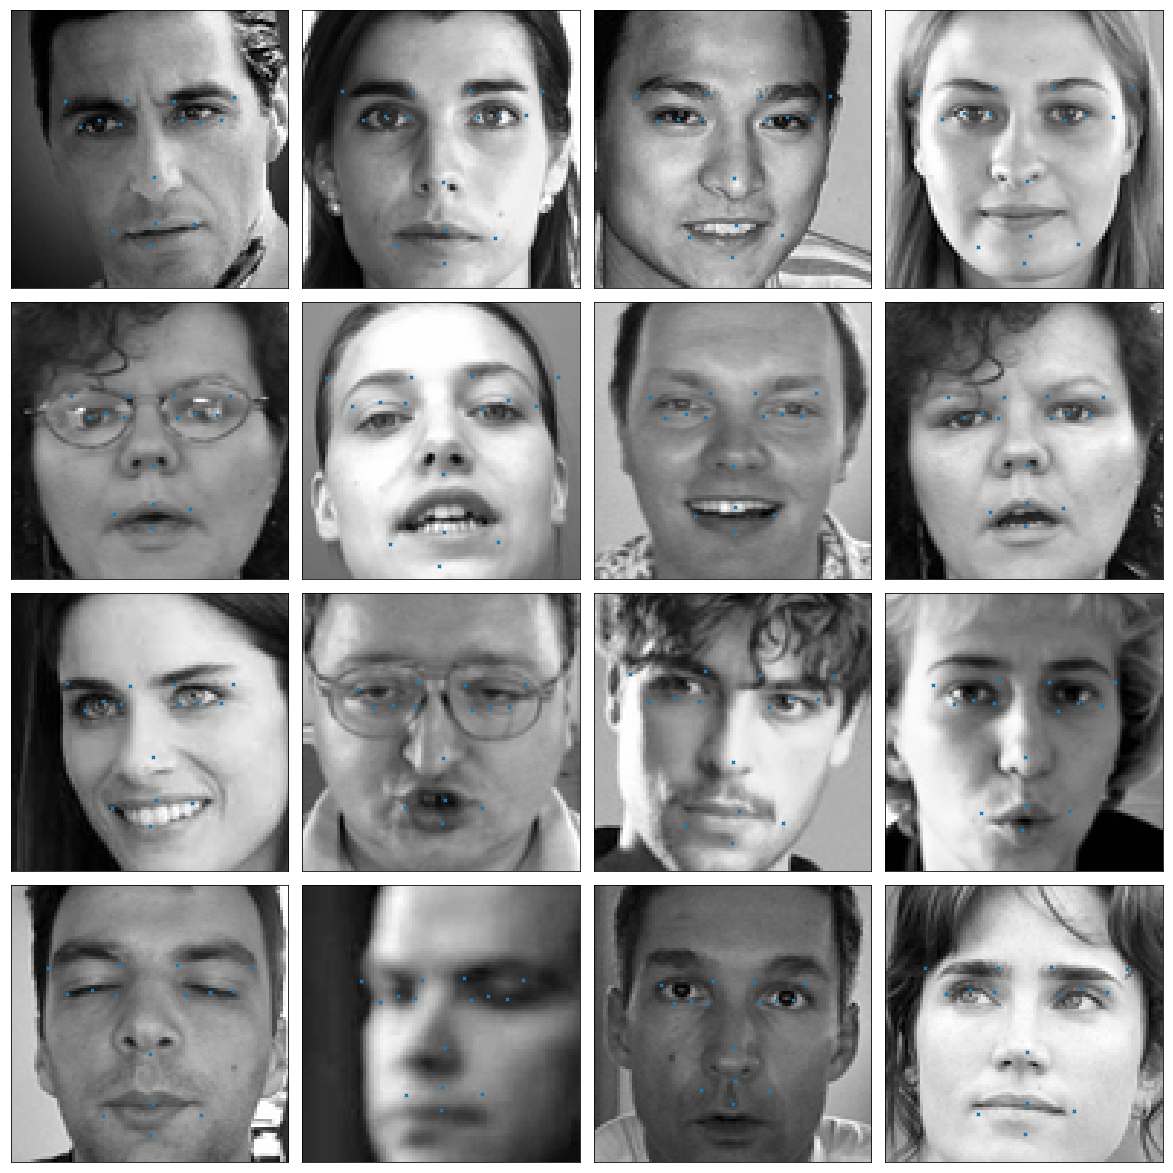

In [216]:
np.random.seed(1)
graph_base = tf.Graph()
with graph_base.as_default():

    if tensorboard_log:
        now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
        logdir = "{}/run-{}/".format(root_logdir, now)

    # def 
    # is_train = True
    #input data
    X = tf.placeholder(tf.float32,[None,X.shape[1]])
    y = tf.placeholder(tf.float32,[None,y.shape[1]])
    training = tf.placeholder(tf.bool)
    
    
    
    #convert x into 4-D input
    #2nd and 3rd dimension is image width and height, final dimension is number of color channels
    x_image = tf.reshape(X,[-1,96,96,1]) 

    #First convolutional layer
    with tf.variable_scope('conv1'):
        layer_conv1, weights_conv1 = new_conv_relu_layer (input = x_image, 
                                                          filter_size = filter_size1, 
                                                          num_filters = num_filters1, 
                                                          is_training = training,
                                                          dropout_keep_prob = dropout_keep_prob1)

    #Second convolutional layer
    with tf.variable_scope('conv2'):
        layer_conv2, weights_conv2 = new_conv_relu_layer (input = layer_conv1, 
                                                          filter_size = filter_size2, 
                                                          num_filters = num_filters2, 
                                                          is_training = training,
                                                          dropout_keep_prob = dropout_keep_prob2)

    #Thrid convolutional layer
    with tf.variable_scope('conv3'):
        layer_conv3, weights_conv3 = new_conv_relu_layer (input = layer_conv2, 
                                                          filter_size = filter_size3, 
                                                          num_filters = num_filters3, 
                                                          is_training = training,
                                                          dropout_keep_prob = dropout_keep_prob3)    

    #Flatten conv3 output for dense nn layer 1
    layer_flat, num_features = flatten_layer(layer_conv3)

    #Densely connected layer1
    with tf.variable_scope('fc4'):
        layer_fc4 = new_fc_layer(input =layer_flat,
                                num_inputs = num_features,
                                num_outputs = fc_size4,
                                use_relu = True,
                                is_training = training,
                                dropout_keep_prob = dropout_keep_prob4)

    #Densely connected layer2
    with tf.variable_scope('fc5'):
        layer_fc5 = new_fc_layer(input =layer_fc4,
                                num_inputs = fc_size4,
                                num_outputs = fc_size5,
                                use_relu = True,
                                is_training = training,
                                dropout_keep_prob = dropout_keep_prob5)    

    #Densely connected output layer
    with tf.variable_scope('fc6'):
        layer_f6 = new_fc_layer(input =layer_fc5,
                                num_inputs = fc_size5,
                                num_outputs = n_outputs,
                                use_relu = False,
                                is_training = training,
                                dropout_keep_prob = dropout_keep_prob6)       


    #loss function
    with tf.name_scope('loss'):
        loss = tf.reduce_mean(np.square(layer_f6 - y))
        sqrt_loss = tf.sqrt(loss)
        
    #for tensorboard
    with tf.name_scope('summaries'):
        sqrt_loss_summary = tf.summary.scalar('sqrt_loss', sqrt_loss)
        
    #for saving
    #with tf.name_scope(model_name):

        
    # optimizer
    optimizer = optimize_func(learning_rate = learning_rate,momentum = momentum,use_nesterov = True).minimize(loss)

    train_loss_data = np.zeros((n_epochs,2))
    dev_loss_data = np.zeros((n_epochs,2))
    y_pred = np.zeros((x_dev.shape[0],y.shape[1]))

    # logger
    if tensorboard_log:
        train_writer = tf.summary.FileWriter(logdir + '/train', tf.get_default_graph())
        dev_writer =  tf.summary.FileWriter(logdir + '/dev')

    
time_start = time.time()
time_1000_start = time.time()

    
with tf.Session(graph=graph_base) as sess:
    sess.run(tf.global_variables_initializer())
    
    #for saving model 
    saver = tf.train.Saver()
    
     
        
    #initializing weights from a previous session 
    initialising_model = "basic_conv_net_1"
        #initialising_model = "3con_2fc_b36_e9_aug_lrdec_mominc_dr"
        
    print(" RESTORING SESSION FOR WEIGHTS INITIALIZATION")
        # Exclude output layer weights from variables we will restore
    for var in tf.global_variables():
        print('all variables: ' + var.op.name)
        #variables_to_restore = [v for v in tf.global_variables() if "fc6" not in v.op.name]
        #print("length",len(variables_to_restore))
        # Replace variables scope with that of the current model
        #loader = tf.train.Saver({v.op.name.replace(facial_model_label['name'], initialising_model): v for v in variables_to_restore})
        #loader = tf.train.Saver({v.op.name.replace(loss, initialising_model): v for v in variables_to_restore})
    load_path = FROOT + "/models/" + initialising_model + "/model.ckpt"
    saver.restore(sess, load_path)
    print(" Model loaded from: " + load_path)
    
    for epoch in range(n_epochs):
        #print('starting epoch:',epoch)
        
        loss_train,loss_dev = shuffle_run_batch (x_train, y_train, x_dev, y_dev, batch_size, epoch)

        train_loss_data[epoch,:] = epoch,np.sqrt(loss_train)
        dev_loss_data[epoch,:] = epoch,np.sqrt(loss_dev)

        
        if epoch%5 == 0:
            print(epoch,'Train loss:%0.3f'%np.sqrt(loss_train),'Dev loss:%0.3f'%np.sqrt(loss_dev),'ratio train/dev:%0.2f'%np.sqrt(loss_train/loss_dev))
        
    time_end = time.time()
    print('Total time taken:',time_end-time_start)
    
    # Save model weights for future use.
    
    
    save_path = saver.save(sess, model_path)
    print("Model file: " + save_path)
    np.savez(train_history_path, train_loss_history = train_loss_data, valid_loss_history = dev_loss_data)
    print("Train history file: " + train_history_path)
    
    for i in range(int(x_dev.shape[0]//batch_size)): #doing predictions in batches
            X_batch = x_dev[i*batch_size:(i+1)*batch_size,:]
            y_pred [i*batch_size:(i+1)*batch_size] = sess.run(layer_f6,feed_dict = {X:X_batch, training:False})

#Plot a graph of the train vs test loss data:
    

plot_loss (train_loss_data, dev_loss_data)

if tensorboard_log:
    train_writer.close()
    dev_writer.close()

#Examine a few test cases to see accuracy of prediction:    
plot_pred (x_dev, y_pred)

# 
# def plot_sample(x, y, axis):
#     img = x.reshape(96, 96)
#     axis.imshow(img, cmap='gray')
#     axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

# fig = plt.figure(figsize=(16, 16))
# fig.subplots_adjust(
#     left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# for i in range(16):
#     ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
#     plot_sample(X_test[i], y_pred[i], ax)

# plt.show()



# Individual Facial parts model

## Individual model settings

On examining the number of datapoints available for each feature, individual models are made by grouping similar features based on number of data points availabe. the main idea being to maximize use of data. Below is the reasoning behind combining different labels.

1. First I considered putting all eye data into one model, but as we can see above that left_eye_center_x, left_eye_center_y, right_eye_center_x , right_eye_center_y have more than 7000 data points while the remining
eye data points only have 2267 - 2271 data points. So eye data points have been split into two models namely eye center and eye corner.
left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036

#### Facial_group_models - Thirty keypoints have been grouped in six types to create specialized models
#### These specialized models are eye_center, eye_corners, nose_tip, mouth_corner_top, mouth_bottom and eyebrow.

In [202]:
#Uncomment the dict to run a particular model
facial_group_labels = [
   
    dict(
        name = "mouth_corner_top",
        columns = (
            'mouth_left_corner_x', 'mouth_left_corner_y',
            'mouth_right_corner_x', 'mouth_right_corner_y',
            'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
            )),
     
#      dict(
#          name = "nose_tip",
#          columns = (
#              'nose_tip_x', 'nose_tip_y',
#              )),

#     dict(
#         name = "mouth_bottom",
#         columns = (
#             'mouth_center_bottom_lip_x',
#             'mouth_center_bottom_lip_y',
#             )),

#     dict(
#         name = "eye_corner",
#         columns = (
#             'left_eye_inner_corner_x', 'left_eye_inner_corner_y',
#             'right_eye_inner_corner_x', 'right_eye_inner_corner_y',
#             'left_eye_outer_corner_x', 'left_eye_outer_corner_y',
#             'right_eye_outer_corner_x', 'right_eye_outer_corner_y',
#             )),
#
    dict(
        name = "eyebrow",
        columns = (
            'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y',
            'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y',
            'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y',
            'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
            )),
    
#      dict(
#         name = "eye_center",
#         columns = (
#             'left_eye_center_x', 'left_eye_center_y',
#             'right_eye_center_x', 'right_eye_center_y',
#             )),
    ]    

In [222]:
def train_individual_model(facial_model_label):
    
    np.random.seed(1)
    graph_base = tf.Graph()
    
    X, y = load(cols = facial_model_label['columns'])
    num_keypoints = y.shape[1]
    
    unique_name = ""
    model_name = "ind_model_" + facial_model_label['name'] + "_" + unique_name
    model_path =  FROOT + "/models/"+ model_name + "/model.ckpt"
    train_history_path = FROOT + "/models/" + model_name + "/train_history"
    
    np.random.seed(0)
    dev_size = 0.2
    #setting aside a 20% sample for validation

    x_train, x_dev, y_train, y_dev = train_test_split(X, y, test_size = dev_size)

    x_test, _ = load(test=True)

    print('Training data split into train and dev data')
    print("x_train.shape = = {}; x_train.min == {:.3f}; x_train.max == {:.3f}".format(x_train.shape, x_train.min(),x_train.max()))
    print("y_train.shape = = {}; y_train.min == {:.3f}; y_train.max == {:.3f}".format(y_train.shape, y_train.min(),y_train.max()))
    print("x_dev.shape = = {}; x_dev.min == {:.3f}; x_dev.max == {:.3f}".format(x_dev.shape, x_dev.min(),x_dev.max()))
    print("y_dev.shape = = {}; y_dev.min == {:.3f}; y_dev.max == {:.3f}".format(y_dev.shape, y_dev.min(),y_dev.max()))
    momentum = 0.9
    with graph_base.as_default():

        if tensorboard_log:
            now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
            logdir = "{}/run-{}/".format(root_logdir, now)

    
        X = tf.placeholder(tf.float32,[None,X.shape[1]])
        y = tf.placeholder(tf.float32,[None,y.shape[1]])
        training = tf.placeholder(tf.bool)
    
        #convert x into 4-D input
        #2nd and 3rd dimension is image width and height, final dimension is number of color channels
        x_image = tf.reshape(X,[-1,96,96,1]) 
    
        

        #First convolutional layer
        with tf.variable_scope('conv1'):
            layer_conv1, weights_conv1 = new_conv_relu_layer (input = x_image, 
                                                          filter_size = filter_size1, 
                                                          num_filters = num_filters1, 
                                                          is_training = training,
                                                          dropout_keep_prob = dropout_keep_prob1)

        #Second convolutional layer
        with tf.variable_scope('conv2'):
            layer_conv2, weights_conv2 = new_conv_relu_layer (input = layer_conv1, 
                                                          filter_size = filter_size2, 
                                                          num_filters = num_filters2, 
                                                          is_training = training,
                                                          dropout_keep_prob = dropout_keep_prob2)

        #Thrid convolutional layer
        with tf.variable_scope('conv3'):
            layer_conv3, weights_conv3 = new_conv_relu_layer (input = layer_conv2, 
                                                          filter_size = filter_size3, 
                                                          num_filters = num_filters3, 
                                                          is_training = training,
                                                          dropout_keep_prob = dropout_keep_prob3)    

        #Flatten conv3 output for dense nn layer 1
        layer_flat, num_features = flatten_layer(layer_conv3)

        #Densely connected layer1
        with tf.variable_scope('fc4'):
            layer_fc4 = new_fc_layer(input =layer_flat,
                                num_inputs = num_features,
                                num_outputs = fc_size4,
                                use_relu = True,
                                is_training = training,
                                dropout_keep_prob = dropout_keep_prob4)

        #Densely connected layer2
        with tf.variable_scope('fc5'):
            layer_fc5 = new_fc_layer(input =layer_fc4,
                                num_inputs = fc_size4,
                                num_outputs = fc_size5,
                                use_relu = True,
                                is_training = training,
                                dropout_keep_prob = dropout_keep_prob5)    

        #Densely connected output layer
        with tf.variable_scope('fc6'):
            layer_f6 = new_fc_layer(input =layer_fc5,
                                num_inputs = fc_size5,
                                num_outputs = num_keypoints,
                                use_relu = False,
                                is_training = training,
                                dropout_keep_prob = dropout_keep_prob6)       


        #loss function
        with tf.variable_scope(facial_model_label['name']):
            #with tf.name_scope('loss'):
            loss = tf.reduce_mean(np.square(layer_f6 - y))
            sqrt_loss = tf.sqrt(loss)
        
        #for tensorboard
        with tf.name_scope('summaries'):
            sqrt_loss_summary = tf.summary.scalar('sqrt_loss', sqrt_loss)

        current_epoch = tf.Variable(0)  # count the number of epochs
        
        #making changes to learning rate and momentum for individual models
        # learning rate decay. - Idea is to start with high learning rate to speed up but decrease as we get closer to 
        #the local optimum so that we don't surpass it.
        learning_rate = tf.train.exponential_decay(0.03, current_epoch, decay_steps = n_epochs, decay_rate = 0.03)
        #momentum = 0.9 + (0.99 - 0.9) * (current_epoch / n_epochs)
        # optimizer
        optimizer = optimize_func(learning_rate = learning_rate,momentum = momentum,use_nesterov = True).minimize(loss)
            
    
        

        train_loss_data = np.zeros((n_epochs,2))
        dev_loss_data = np.zeros((n_epochs,2))
        y_pred = np.zeros((x_dev.shape[0],y.shape[1]))

        # logger
        if tensorboard_log:
            train_writer = tf.summary.FileWriter(logdir + '/train', tf.get_default_graph())
            dev_writer =  tf.summary.FileWriter(logdir + '/dev')

    
    time_start = time.time()
    time_1000_start = time.time()

    
    with tf.Session(graph=graph_base) as sess:
        sess.run(tf.global_variables_initializer())
    
        #for saving model 
        saver = tf.train.Saver()
        
        #initializing weights from a previous session 
        initialising_model = "basic_conv_net_1"
        #initialising_model = "3con_2fc_b36_e9_aug_lrdec_mominc_dr"
        
        print(" RESTORING SESSION FOR WEIGHTS INITIALIZATION")
        # Exclude output layer weights from variables we will restore
        for var in tf.global_variables():
            print('all variables: ' + var.op.name)
        variables_to_restore = [v for v in tf.global_variables() if "fc6" not in v.op.name]
        print("length",len(variables_to_restore))
        # Replace variables scope with that of the current model
        loader = tf.train.Saver({v.op.name.replace(facial_model_label['name'], initialising_model): v for v in variables_to_restore})
        #loader = tf.train.Saver({v.op.name.replace(loss, initialising_model): v for v in variables_to_restore})
        load_path = FROOT + "/models/" + initialising_model + "/model.ckpt"
        loader.restore(sess, load_path)
        print(" Model loaded from: " + load_path)
    
        for epoch in range(n_epochs):
        #print('starting epoch:',epoch)
            current_epoch = epoch
            shuffle = np.random.permutation(np.arange(x_train.shape[0])) #shuffle the training data in each epoch
            x_train, y_train = x_train[shuffle], y_train[shuffle]

            # initialize variables to hold loss information for each epoch
    
            batches = x_train.shape[0]//batch_size

            
            
            for i in range(int(batches)): #run through most of the data points in each epoch
        
                X_batch,y_batch = x_train[i*batch_size:(i+1)*batch_size,:], y_train[i*batch_size:(i+1)*batch_size]
                sess.run(optimizer, feed_dict = {X:X_batch,y:y_batch, training:True})
        
                if tensorboard_log:
                    if i % 10 == 0:
                        train_summary_str = sqrt_loss_summary.eval(feed_dict={X: X_batch, y: y_batch, training: True})
                        dev_summary_str = sqrt_loss_summary.eval(feed_dict={X: Xdev, y: ydev, training: False})
                        step = epoch * batches + i
                        train_writer.add_summary(train_summary_str, step)
                        dev_writer.add_summary(dev_summary_str, step)
            
            

    

            loss_train = loss.eval(feed_dict = {X:X_batch,y:y_batch,  training:True})            
            loss_dev = loss.eval(feed_dict = {X:x_dev,y:y_dev, training:False})
            train_loss_data[epoch,:] = epoch,np.sqrt(loss_train)
            dev_loss_data[epoch,:] = epoch,np.sqrt(loss_dev)

        
            if epoch%5 == 0:
                print(epoch,'Train loss:%0.3f'%np.sqrt(loss_train),'Dev loss:%0.3f'%np.sqrt(loss_dev),'ratio train/dev:%0.2f'%np.sqrt(loss_train/loss_dev))
        
        time_end = time.time()
        print('Total time taken:',time_end-time_start)
    
        # Save model weights for future use.
        #please give any unique name you want to give to the model for testing various paramaters.
        #It wil get appended to ""basic_conv_net"
        
        save_path = saver.save(sess, model_path)
        print("Model file: " + save_path)
        np.savez(train_history_path, train_loss_history = train_loss_data, valid_loss_history = dev_loss_data)
        print("Train history file: " + train_history_path)
    
        for i in range(int(x_dev.shape[0]//batch_size)): #doing predictions in batches
            X_batch = x_dev[i*batch_size:(i+1)*batch_size,:]
            y_pred [i*batch_size:(i+1)*batch_size] = sess.run(layer_f6,feed_dict = {X:X_batch, training:False})

    #Plot a graph of the train vs dev loss data:
    
    #plt.figure()
    plot_loss (train_loss_data, dev_loss_data)
    print("\n")
    plot_pred (x_dev, y_pred)
    print("\n")
    if tensorboard_log:
        train_writer.close()
        dev_writer.close()
    
    




In [223]:
start = time.time()

for facial_model_label in facial_group_labels:
    train_individual_model(facial_model_label)

time_stop = time.time()    
print(" Total time for all models: " , time_stop - start)    
    

Count of observations in training data by features
mouth_left_corner_x       2269
mouth_left_corner_y       2269
mouth_right_corner_x      2270
mouth_right_corner_y      2270
mouth_center_top_lip_x    2275
mouth_center_top_lip_y    2275
Image                     7049
dtype: int64
Count of observations in training data by features
ImageId    1783
Image      1783
dtype: int64
Training data split into train and dev data
x_train.shape = = (1808, 9216); x_train.min == 0.000; x_train.max == 1.000
y_train.shape = = (1808, 6); y_train.min == -0.942; y_train.max == 0.990
x_dev.shape = = (452, 9216); x_dev.min == 0.000; x_dev.max == 1.000
y_dev.shape = = (452, 6); y_dev.min == -0.953; y_dev.max == 0.961
 RESTORING SESSION FOR WEIGHTS INITIALIZATION
all variables: conv1/weights
all variables: conv1/biases
all variables: conv2/weights
all variables: conv2/biases
all variables: conv3/weights
all variables: conv3/biases
all variables: fc4/weights
all variables: fc4/biases
all variables: fc5/weights


NotFoundError: Key Variable not found in checkpoint
	 [[Node: save_1/RestoreV2 = RestoreV2[dtypes=[DT_INT32], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_1/Const_0_0, save_1/RestoreV2/tensor_names, save_1/RestoreV2/shape_and_slices)]]

Caused by op 'save_1/RestoreV2', defined at:
  File "/Users/anamika/anaconda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/anamika/anaconda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/anamika/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/anamika/anaconda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/anamika/anaconda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/Users/anamika/anaconda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/anamika/anaconda/lib/python3.6/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/Users/anamika/anaconda/lib/python3.6/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/anamika/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/anamika/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/anamika/anaconda/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/anamika/anaconda/lib/python3.6/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/anamika/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/anamika/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/anamika/anaconda/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Users/anamika/anaconda/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/anamika/anaconda/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/anamika/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/anamika/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/anamika/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-223-e35479b16d02>", line 4, in <module>
    train_individual_model(facial_model_label)
  File "<ipython-input-222-6420fb6215ed>", line 154, in train_individual_model
    loader = tf.train.Saver({v.op.name.replace(facial_model_label['name'], initialising_model): v for v in variables_to_restore})
  File "/Users/anamika/anaconda/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1218, in __init__
    self.build()
  File "/Users/anamika/anaconda/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1227, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/Users/anamika/anaconda/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1263, in _build
    build_save=build_save, build_restore=build_restore)
  File "/Users/anamika/anaconda/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 751, in _build_internal
    restore_sequentially, reshape)
  File "/Users/anamika/anaconda/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 427, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/Users/anamika/anaconda/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 267, in restore_op
    [spec.tensor.dtype])[0])
  File "/Users/anamika/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1021, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "/Users/anamika/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/anamika/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/Users/anamika/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

NotFoundError (see above for traceback): Key Variable not found in checkpoint
	 [[Node: save_1/RestoreV2 = RestoreV2[dtypes=[DT_INT32], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_1/Const_0_0, save_1/RestoreV2/tensor_names, save_1/RestoreV2/shape_and_slices)]]
